In [1]:
# instalar packages extras
!pip install geopandas
!pip install pygeos
!pip install feature-engine

In [2]:
# Ferramentas necessárias
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import scipy.stats as stats
import matplotlib.pyplot as plt
from shapely.geometry import Point
gpd.options.use_pygeos = True
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
pd.options.display.max_columns = None

In [3]:
# Dataset base, contém a variável alvo e rua, que será usada pra expandir a dimensionalidade do dataset
dados_imoveis_sp = pd.read_excel('/content/drive/MyDrive/imersao_dados/Sao paulo.xlsx')

In [5]:
# Remover linhas duplicadas
dados_imoveis_sp.drop_duplicates(inplace = True)

In [6]:
dados_imoveis_sp

,Street,City,propertycard__detailvalue,quartos,banheiros,vagas,price
0,"Avenida Itacira, 255","Planalto Paulista, São Paulo",1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42","Jardim dos Estados, São Paulo",469-524,3-6,3-6,4,R$ 3.700.000
2,Rua Alba Valdez,"Jardim Reimberg, São Paulo",125,4,3,2,R$ 380.000
3,"Jardim Morumbi, São Paulo",SP,310,3,2,4,R$ 685.000
4,"Rua Tobias Barreto, 195","Mooca, São Paulo",100,3,2,2,R$ 540.000
...,...,...,...,...,...,...,...
9956,Rua Tapuçu,"Vila Sofia, São Paulo",90,2,2,2,R$ 665.000
9957,Rua Guararema,"Bosque da Saúde, São Paulo",600,8,7,5,R$ 2.300.000
9958,Rua Estero Belaco,"Vila da Saúde, São Paulo",200,3,3,6,R$ 1.050.000
9959,"Rua Manuel Onha, , 514","Vila Oratório, São Paulo",180,3,2,2,R$ 2.200\n /Mês


In [7]:
# Renomear valores para português
dados_imoveis_sp.rename(columns={"Street": "rua", "City": "cidade", "propertycard__detailvalue": "area", "price":"valor"}, inplace = True)

In [8]:
# Remover espaços no começo e fim de todos valores na variável cidade
dados_imoveis_sp['cidade'] = dados_imoveis_sp['cidade'].apply(lambda x: str(x).strip())

In [9]:
dados_imoveis_sp

,rua,cidade,area,quartos,banheiros,vagas,valor
0,"Avenida Itacira, 255","Planalto Paulista, São Paulo",1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42","Jardim dos Estados, São Paulo",469-524,3-6,3-6,4,R$ 3.700.000
2,Rua Alba Valdez,"Jardim Reimberg, São Paulo",125,4,3,2,R$ 380.000
3,"Jardim Morumbi, São Paulo",SP,310,3,2,4,R$ 685.000
4,"Rua Tobias Barreto, 195","Mooca, São Paulo",100,3,2,2,R$ 540.000
...,...,...,...,...,...,...,...
9956,Rua Tapuçu,"Vila Sofia, São Paulo",90,2,2,2,R$ 665.000
9957,Rua Guararema,"Bosque da Saúde, São Paulo",600,8,7,5,R$ 2.300.000
9958,Rua Estero Belaco,"Vila da Saúde, São Paulo",200,3,3,6,R$ 1.050.000
9959,"Rua Manuel Onha, , 514","Vila Oratório, São Paulo",180,3,2,2,R$ 2.200\n /Mês


In [10]:
# Criar lista com valores únicos da coluna cidade, que deve conter "Sao Paulo"
# Ordenar e armazenar os valores que não contém "Sao Paulo" como substring em lista
# https://stackoverflow.com/questions/66577531/can-someone-please-explain-this-line-of-code-for-sorting-list-using-key-as-param
l = list(dados_imoveis_sp['cidade'].unique())
l.sort(key=lambda v: (isinstance(v, str), v)) 
errado = [i for i in l if "São Paulo" not in str(i)]
errado

['8888',
 'A',
 'Açu',
 'Açu, 55',
 'Batuá',
 'Brasil',
 'Brasil, 10',
 'Brasil, 380',
 'Condomínio Residencial Monaco, São José dos Campos',
 'Flores, 74',
 'Guainumbi',
 'Guaçu',
 'Ipatinga, Sorocaba',
 'Kehir',
 'Noa',
 'Residencial de Lorenzi, Boituva',
 'SP',
 'Santa Cruz dos Lázaros, Jacareí',
 'Vila Poupança, Santana de Parnaíba',
 'Vila São Benedito, Pindamonhangaba',
 'acu',
 'de',
 'do']

In [11]:
# Verifica-se que há restos de nomes de ruas na coluna 'cidade'
# a lista a seguir filtra e adiciona o tipo nulo 'nan' nas cidades erradas
cidade_err = ['nan',
'A',
'Açu',
'Açu, 55',
'Batuá',
'Brasil',
'Brasil, 10',
'Brasil, 380',
'Flores, 74',
'Guainumbi',
'Guaçu',
'Kehir',
'Noa',
'acu',
'de',
'do',
8888]
dados_imoveis_sp[dados_imoveis_sp['cidade'].isin(cidade_err)]

,rua,cidade,area,quartos,banheiros,vagas,valor
49,"Rua Artur Montenegro, 9",A,250,2,2,2,R$ 370.000
104,Rua Marechal,do,360,4,5,4,R$ 1.800.000
193,Rua Guira,Guainumbi,180,4,2,1,R$ 300.000
254,Travessa Palma,de,125,2,1,1,R$ 370.000
263,Rua Palmeira,Batuá,120,3,3,2,R$ 550.000
823,Rua Marechal,do,360,4,4,4,R$ 1.800.000
994,Rua Pau,Brasil,553,3,7,4,R$ 6.750.000
2359,Rua Pau,Brasil,296,3,2,5,R$ 2.750.000
3059,Rua Alcacer,Kehir,233,3,2,2,R$ 860.000
3253,Rua Pau,Brasil,422,4,4,6,R$ 4.500.000


In [12]:
def reconstruir_nome_rua(df,var):

    df[var] = df[var].apply(lambda x: x.split("-") if "-" in str(x) else x)
    df[var] = df[var].apply(lambda x: [int(el) for el in x] if isinstance(x, list) else x)
    df[var] = df[var].apply(lambda x: round(np.mean(x)) if isinstance(x, list) else x)

    return df

for variavel in ['area','quartos', 'banheiros', 'vagas']:
    reconstruir_nome_rua(dados_imoveis_sp, variavel)

# Juntar colunas rua e cidade, onde o valor em cidade é nome da rua
dados_imoveis_sp['rua'] = dados_imoveis_sp.apply(lambda x: str(x.rua) + ' ' + str(x.cidade) 
                                                           if x.cidade in cidade_err else x.rua, axis = 1)

In [13]:
# Remover as linhas que não tem rua, pois a cidade está no lugar
city_sp = dados_imoveis_sp[dados_imoveis_sp['cidade'] == 'SP']

In [14]:
# Verificar que todas as linhas em city_sp realmente têm o nome da cidade no lugar da rua
bool_series = city_sp['rua'].apply(lambda x: True if "São Paulo" in x else False)
bool_series.unique()

array([ True])

In [15]:
city_sp

,rua,cidade,area,quartos,banheiros,vagas,valor
3,"Jardim Morumbi, São Paulo",SP,310,3,2,4,R$ 685.000
11,"Jardim Luzitânia, São Paulo",SP,436,4,3,3,R$ 15.000
33,"Parque da Lapa, São Paulo",SP,220,4,4,3,R$ 849.000
58,"Chácara Santo Antônio (Zona Sul), São Paulo",SP,190,2,2,2,R$ 1.100.000
59,"Jardim Guedala, São Paulo",SP,650,4,6,4,R$ 5.500.000
...,...,...,...,...,...,...,...
9917,"Vila Esperança, São Paulo",SP,90,2,3,4,R$ 430.000
9942,"Parque Alves de Lima, São Paulo",SP,122,2,1,2,R$ 400.000
9944,"Vila Formosa, São Paulo",SP,140,3,2,3,R$ 750.000
9948,"Jardim Leonor, São Paulo",SP,1345,5,9,7,R$ 9.500.000


In [16]:
# Separar coluna valor em 3, 'tipo_anuncio' vai mostrar aquelas que são aluguéis
dados_imoveis_sp[['moeda','valor','tipo_anuncio']] = dados_imoveis_sp['valor'].str.split(expand = True)

In [17]:
dados_imoveis_sp

,rua,cidade,area,quartos,banheiros,vagas,valor,moeda,tipo_anuncio
0,"Avenida Itacira, 255","Planalto Paulista, São Paulo",1000,4,8,6,7.000.000,R$,None
1,"Rua Aurelia Perez Alvarez, 42","Jardim dos Estados, São Paulo",496,4,4,4,3.700.000,R$,None
2,Rua Alba Valdez,"Jardim Reimberg, São Paulo",125,4,3,2,380.000,R$,None
3,"Jardim Morumbi, São Paulo",SP,310,3,2,4,685.000,R$,None
4,"Rua Tobias Barreto, 195","Mooca, São Paulo",100,3,2,2,540.000,R$,None
...,...,...,...,...,...,...,...,...,...
9956,Rua Tapuçu,"Vila Sofia, São Paulo",90,2,2,2,665.000,R$,None
9957,Rua Guararema,"Bosque da Saúde, São Paulo",600,8,7,5,2.300.000,R$,None
9958,Rua Estero Belaco,"Vila da Saúde, São Paulo",200,3,3,6,1.050.000,R$,None
9959,"Rua Manuel Onha, , 514","Vila Oratório, São Paulo",180,3,2,2,2.200,R$,/Mês


In [18]:
def tira_pontos(numero):

  if numero:
    lista_algarismos = numero.split('.')
    numero_real = ''.join(lista_algarismos)
    return int(numero_real)

# Retira '.' da coluna valor
dados_imoveis_sp['valor'] = dados_imoveis_sp['valor'].apply(lambda x: tira_pontos(x))

In [19]:
# Retira números das ruas e depois transforma tudo em minúsculo
dados_imoveis_sp["rua"] = dados_imoveis_sp["rua"].str.extract(r'(^[\w ]+)')
dados_imoveis_sp["rua"] = dados_imoveis_sp["rua"].str.lower().str.strip()

In [20]:
# Transforma as colunas em floats para encaixar no modelo de regressão
dados_imoveis_sp[['area', 'quartos',	
                  'banheiros', 'vagas', 'valor']]	= dados_imoveis_sp[['area', 'quartos',	
                                                                      'banheiros', 'vagas', 'valor']].astype(float, copy = False)	

In [21]:
# Filtra as linhas cujos valores são de venda e não aluguel
dados_venda_imoveis = dados_imoveis_sp[dados_imoveis_sp['tipo_anuncio'].isnull() == True]
dados_venda_imoveis

,rua,cidade,area,quartos,banheiros,vagas,valor,moeda,tipo_anuncio
0,avenida itacira,"Planalto Paulista, São Paulo",1000.0,4.0,8.0,6.0,7000000.0,R$,None
1,rua aurelia perez alvarez,"Jardim dos Estados, São Paulo",496.0,4.0,4.0,4.0,3700000.0,R$,None
2,rua alba valdez,"Jardim Reimberg, São Paulo",125.0,4.0,3.0,2.0,380000.0,R$,None
3,jardim morumbi,SP,310.0,3.0,2.0,4.0,685000.0,R$,None
4,rua tobias barreto,"Mooca, São Paulo",100.0,3.0,2.0,2.0,540000.0,R$,None
...,...,...,...,...,...,...,...,...,...
9955,avenida odila,"Planalto Paulista, São Paulo",262.0,3.0,6.0,4.0,1500000.0,R$,None
9956,rua tapuçu,"Vila Sofia, São Paulo",90.0,2.0,2.0,2.0,665000.0,R$,None
9957,rua guararema,"Bosque da Saúde, São Paulo",600.0,8.0,7.0,5.0,2300000.0,R$,None
9958,rua estero belaco,"Vila da Saúde, São Paulo",200.0,3.0,3.0,6.0,1050000.0,R$,None


In [22]:
# Contém o nome das ruas como no dataset anterior e duas colunas de coordenadas geográficas (latitude e longitude)
enderecos = pd.read_csv('/content/drive/MyDrive/imersao_dados/enderecos.csv') 

# Dataset com um código de setor (correspondente a 'Cod_setor') e um polígono (geopamdas) delimitado por latitude e longitude
setor_censo = gpd.read_file('/content/drive/MyDrive/imersao_dados/35SEE250GC_SIR.shp')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
# Selecionar amostras do estado de SP  
# Juntar as partes dos nomes das ruas
# passar ruas para minúsculo e remover espaços do começo e fim da string, como no dataset inicial
enderecos_sp = enderecos.query("sigla_uf == 'SP'")
enderecos_sp["rua"] = enderecos_sp["tipo_logr"] + " " + enderecos_sp["logr_nome"]
enderecos_sp["rua"] = enderecos_sp["rua"].str.lower().str.strip()

# Selecionar apenas os endereços da cidade de São Paulo
setor_censo_sp = setor_censo[setor_censo.NM_MUNICIP == "SÃO PAULO"]

In [24]:
# Unir o primeiro dataset, aos dados do dataset que contém as coordenadas geográficas (latitude e longitude), pelo nome da rua
# Abandonar as linhas duplicadas, filtrar por CEP não nulo
venda_geo = pd.merge(left = dados_venda_imoveis, right = enderecos_sp[["rua", "cep", "latitude", "longitude"]], 
                     how = "left", left_on = "rua", right_on = "rua").drop_duplicates(
                         subset=dados_venda_imoveis.columns, keep = 'last').query("cep > 0")

In [25]:
venda_geo

,rua,cidade,area,quartos,banheiros,vagas,valor,moeda,tipo_anuncio,cep,latitude,longitude
4,avenida itacira,"Planalto Paulista, São Paulo",1000.0,4.0,8.0,6.0,7000000.0,R$,None,4061003.0,-23.615793,-46.648162
5,rua aurelia perez alvarez,"Jardim dos Estados, São Paulo",496.0,4.0,4.0,4.0,3700000.0,R$,None,4642020.0,-23.640961,-46.688311
6,rua alba valdez,"Jardim Reimberg, São Paulo",125.0,4.0,3.0,2.0,380000.0,R$,None,4845200.0,-23.752990,-46.695889
20,rua tobias barreto,"Mooca, São Paulo",100.0,3.0,2.0,2.0,540000.0,R$,None,19700360.0,-22.408315,-50.574899
21,rua graham bell,"Santo Amaro, São Paulo",440.0,4.0,4.0,6.0,1980000.0,R$,None,4737030.0,-23.593796,-46.760077
...,...,...,...,...,...,...,...,...,...,...,...,...
25823,avenida odila,"Planalto Paulista, São Paulo",262.0,3.0,6.0,4.0,1500000.0,R$,None,4058021.0,-23.608378,-46.647774
25824,rua tapuçu,"Vila Sofia, São Paulo",90.0,2.0,2.0,2.0,665000.0,R$,None,4671185.0,-23.661018,-46.691521
25841,rua guararema,"Bosque da Saúde, São Paulo",600.0,8.0,7.0,5.0,2300000.0,R$,None,6922800.0,-23.625827,-46.806177
25842,rua estero belaco,"Vila da Saúde, São Paulo",200.0,3.0,3.0,6.0,1050000.0,R$,None,4145020.0,-23.616124,-46.632983


In [26]:
# Com o dataset obtido anteriormente, criar um geodataframe que contém um ponto de localização geográfica 
# Formado pelas coordenadas de latitude e longitude
# colocar o mesmo sistema de coordenadas para todos os geodataframes
geodf = gpd.GeoDataFrame(
    venda_geo, geometry=gpd.points_from_xy(venda_geo.longitude, venda_geo.latitude))
geodf = geodf.set_crs('epsg:4674')

In [27]:
# sjoin une os datasets se o ponto na coluna 'geometry' (formada na célula acima)
# Estiver dentro da região no dataset da direita
# Dataset formado contém os dados do primeiro dataset
# A coluna 'CD_GEOCODI' corresponde a 'Cod_setor' do dataset ibge_sp na próxima célula
geo_df_setores = gpd.sjoin(geodf,setor_censo_sp,how="left", predicate='intersects')
geo_df_setores['CD_GEOCODI'] = geo_df_setores['CD_GEOCODI'].astype('str')

In [28]:
# Dataset que contém as variáveis (V001 a V012) a serem agregadas ao dataset
# Cod_setor é o ponto de união com o dataset anterior
ibge_sp = pd.read_csv(
    '/content/drive/MyDrive/imersao_dados/Basico_SP1.csv',
    encoding='ISO-8859-1',
    sep=';', thousands='.', decimal=','
)
ibge_sp['Cod_setor'] = ibge_sp['Cod_setor'].astype('str')

In [29]:
# Unir o dataset que contém a variável alvo e ibge_sp
dados_vendas_censo = geo_df_setores.merge(right = ibge_sp, how = "left", left_on = "CD_GEOCODI", right_on = "Cod_setor")

In [30]:
dados_vendas_censo

,rua,cidade,area,quartos,banheiros,vagas,valor,moeda,tipo_anuncio,cep,latitude,longitude,geometry,index_right,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,Cod_setor,Cod_Grandes Regiï¿½es,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,Nome_da_RM,Cod_municipio,Nome_do_municipio,Cod_distrito,Nome_do_distrito,Cod_subdistrito,Nome_do_subdistrito,Cod_bairro,Nome_do_bairro,Situacao_setor,Tipo_setor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012,Unnamed: 33
0,avenida itacira,"Planalto Paulista, São Paulo",1000.0,4.0,8.0,6.0,7000000.0,R$,None,4061003.0,-23.615793,-46.648162,POINT (-46.64816 -23.61579),58887.0,124412.0,355030877000067,URBANO,35503087700,None,355030877,SAÚDE,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,58888.0,355030877000067,3.0,Regiï¿½o Sudeste,35.0,Sï¿½o Paulo,3515.0,Metropolitana de Sï¿½o Paulo,35061.0,Sï¿½o Paulo,20.0,RM Sï¿½o Paulo,3550308.0,Sï¿½O PAULO,355030877.0,SAï¿½DE,3.550309e+10,SAï¿½DE,3.550308e+09,Sï¿½O PAULO (todos os setores),1.0,0.0,164.0,437.0,2.66,2.04,3158.96,22210644.93,5570.65,25770816.97,2096.19,13029851.56,3930.35,17241576.74,NaN
1,rua aurelia perez alvarez,"Jardim dos Estados, São Paulo",496.0,4.0,4.0,4.0,3700000.0,R$,None,4642020.0,-23.640961,-46.688311,POINT (-46.68831 -23.64096),57581.0,123076.0,355030871000023,URBANO,35503087100,None,355030871,SANTO AMARO,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,57582.0,355030871000023,3.0,Regiï¿½o Sudeste,35.0,Sï¿½o Paulo,3515.0,Metropolitana de Sï¿½o Paulo,35061.0,Sï¿½o Paulo,20.0,RM Sï¿½o Paulo,3550308.0,Sï¿½O PAULO,355030871.0,SANTO AMARO,3.550309e+10,SANTO AMARO,3.550308e+09,Sï¿½O PAULO (todos os setores),1.0,0.0,136.0,425.0,3.13,1.96,7600.44,36778930.17,7890.53,35886906.64,4149.00,26760682.90,6063.92,27502674.90,NaN
2,rua alba valdez,"Jardim Reimberg, São Paulo",125.0,4.0,3.0,2.0,380000.0,R$,None,4845200.0,-23.752990,-46.695889,POINT (-46.69589 -23.75299),48704.0,114197.0,355030830000050,URBANO,35503083000,None,355030830,GRAJAÚ,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,48705.0,355030830000050,3.0,Regiï¿½o Sudeste,35.0,Sï¿½o Paulo,3515.0,Metropolitana de Sï¿½o Paulo,35061.0,Sï¿½o Paulo,20.0,RM Sï¿½o Paulo,3550308.0,Sï¿½O PAULO,355030830.0,GRAJAï¿½,3.550308e+10,GRAJAï¿½,3.550308e+09,Sï¿½O PAULO (todos os setores),1.0,0.0,142.0,493.0,3.47,3.06,805.13,769188.78,1011.75,757433.42,518.77,426672.78,858.51,414378.88,NaN
3,rua tobias barreto,"Mooca, São Paulo",100.0,3.0,2.0,2.0,540000.0,R$,None,19700360.0,-22.408315,-50.574899,POINT (-50.57490 -22.40832),NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,rua graham bell,"Santo Amaro, São Paulo",440.0,4.0,4.0,6.0,1980000.0,R$,None,4737030.0,-23.593796,-46.760077,POINT (-46.76008 -23.59380),56270.0,121838.0,355030865000169,URBANO,35503086500,None,355030865,RAPOSO TAVARES,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,56271.0,355030865000169,3.0,Regiï¿½o Sudeste,35.0,Sï¿½o Paulo,3515.0,Metropolitana de Sï¿½o Paulo,35061.0,Sï¿½o Paulo,20.0,RM Sï¿½o Paulo,3550308.0,Sï¿½O PAULO,355030865.0,RAPOSO TAVARES,3.550309e+10,RAPOSO TAVARES,3.550308e+09,Sï¿½O PAULO (todos os setores),1.0,0.0,107.0,376.0,3.51,2.31,1026.36,272168.67,1143.96,167733.64,735.67,367088.08,1086.94,159622.46,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4364,avenida odila,"Planalto Paulista, São Paulo",262.0,3.0,6.0,4.0,1500000.0,R$,None,4058021.0,-23.608378,-46.647774,POINT (-46.64777 -23.60838),58919.0,124444.0,355030877000099,URBANO,35503087700,None,355030877,SAÚDE,3550308,SÃO PA

In [31]:
# variáveis inúteis são constantes ou inteiramente nulas, não servem de forma nenhuma para o modelo
def variaveis_constantes(df):
    lista_constantes = []
    for column in df.columns:
        if df[column].nunique() <= 1:
             lista_constantes.append(column)
    return lista_constantes    

In [32]:
todas_variaveis_constantes = variaveis_constantes(dados_vendas_censo)

In [33]:
todas_variaveis_constantes

['moeda',
 'tipo_anuncio',
 'NM_SUBDIST',
 'CD_GEOCODM',
 'NM_MUNICIP',
 'NM_MICRO',
 'NM_MESO',
 'CD_GEOCODB',
 'NM_BAIRRO',
 'Cod_Grandes Regiï¿½es',
 'Nome_Grande_Regiao',
 'Cod_UF',
 'Nome_da_UF ',
 'Cod_meso',
 'Nome_da_meso',
 'Cod_micro',
 'Nome_da_micro',
 'Cod_RM',
 'Nome_da_RM',
 'Cod_municipio',
 'Nome_do_municipio',
 'Cod_bairro',
 'Nome_do_bairro',
 'Unnamed: 33']

In [34]:
todas_variaveis_inuteis = todas_variaveis_constantes + ['rua', 'cidade', 'latitude', 'longitude', 'Cod_distrito', 
 'Nome_do_distrito', 'Nome_do_subdistrito','Tipo_setor','cep','Cod_setor', 'Cod_subdistrito','geometry',	'index_right', 
 'ID',	'CD_GEOCODI',	'TIPO',	'CD_GEOCODS',	'CD_GEOCODD',	'NM_DISTRIT',	'ID1','Situacao_setor']

In [35]:
# Remover variáveis nulas, variáveis constantes ou que não acrescentem ao dataset
dados_vendas_censo_sem_constantes = dados_vendas_censo.drop(todas_variaveis_inuteis, axis = 1)

In [36]:
# Verificar outliers da variável área, os dois primeiros estão muito longe dos outros
dados_vendas_censo_sem_constantes.sort_values('area', ascending = False)

,area,quartos,banheiros,vagas,valor,V001,V002,V003,V004,V005,V006,V007,V008,V009,V010,V011,V012
4315,750000.0,5.0,9.0,6.0,7000000.0,106.0,371.0,3.50,2.77,15879.25,1.240184e+08,16184.62,1.214362e+08,6313.35,86798000.32,9256.02,1.000736e+08
2968,37000.0,4.0,2.0,4.0,2900000.0,201.0,646.0,3.21,2.54,991.52,5.731998e+05,1095.03,5.193974e+05,632.37,513743.72,1016.31,4.352248e+05
2247,2850.0,3.0,3.0,10.0,4000000.0,298.0,924.0,3.10,2.08,987.79,9.514425e+05,1123.52,9.295996e+05,636.72,649405.11,955.69,6.699362e+05
3150,2500.0,3.0,7.0,12.0,12500000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3125,2200.0,6.0,9.0,15.0,19800000.0,73.0,230.0,3.15,1.91,5178.68,4.431123e+07,7000.81,4.719931e+07,2649.65,23409666.51,4747.28,3.205630e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141,36.0,2.0,1.0,1.0,196000.0,293.0,868.0,2.96,2.56,1116.38,2.314345e+06,1521.40,2.538828e+06,920.40,1657066.33,1393.48,1.849952e+06
208,36.0,2.0,1.0,1.0,190000.0,293.0,868.0,2.96,2.56,1116.38,2.314345e+06,1521.40,2.538828e+06,920.40,1657066.33,1393.48,1.849952e+06
3737,29.0,1.0,1.0,1.0,300000.0,289.0,929.0,3.21,2.89,1028.52,1.387690e+06,1415.44,1.361943e+06,945.45,2006854.44,1343.36,2.317469e+06
2359,20.0,3.0,2.0,2.0,800000.0,165.0,493.0,2.99,1.71,8300.62,4.474489e+07,9010.55,4.215795e+07,4573.23,34316382.09,6649.24,3.609621e+07


In [37]:
# Remover as duas linhas de valores de área muito discrepantes e de valor também, pois o modelo regressão é muito sensível a eles
dados_vendas_censo_sem_constantes.drop(dados_vendas_censo_sem_constantes.query("area > 30000").index, inplace = True)
dados_vendas_censo_sem_constantes.drop(dados_vendas_censo_sem_constantes.query("valor > 30000000 | valor < 100000").index, inplace = True)

In [38]:
# Verificar se contém valores nulos
vars_num = [var for var in dados_vendas_censo_sem_constantes.columns if var != 'valor']
vars_num_com_na = [
    var for var in vars_num
    if dados_vendas_censo_sem_constantes[var].isnull().sum() > 0
]
dados_vendas_censo_sem_constantes[vars_num_com_na].isnull().mean().sort_values(ascending=False)

V001    0.196285
V002    0.196285
V003    0.196285
V004    0.196285
V005    0.196285
V006    0.196285
V007    0.196285
V008    0.196285
V009    0.196285
V010    0.196285
V011    0.196285
V012    0.196285
dtype: float64

In [39]:
# Remover valores nulos do dataset
dados_vendas_censo_sem_constantes.dropna(inplace = True)

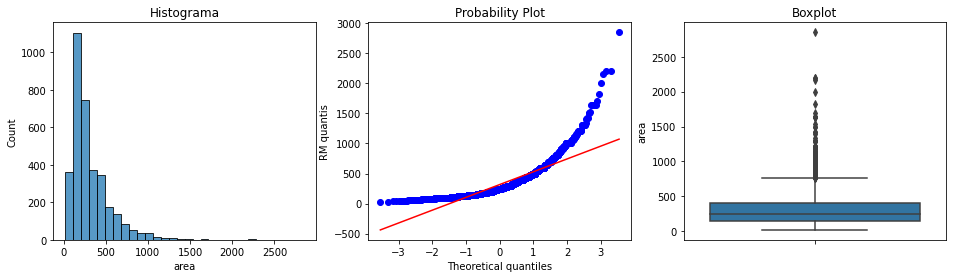

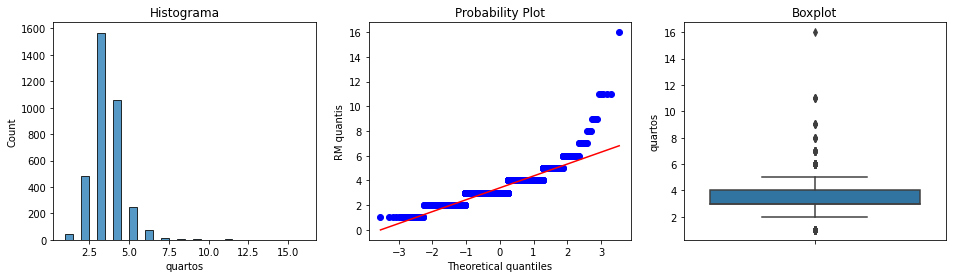

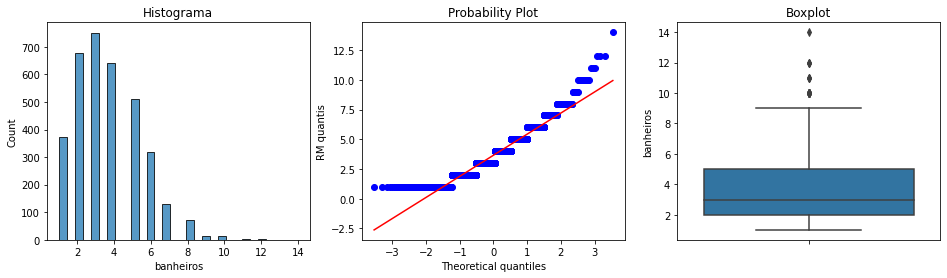

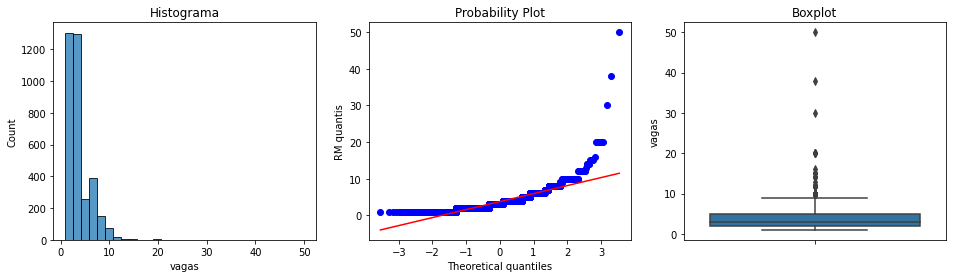

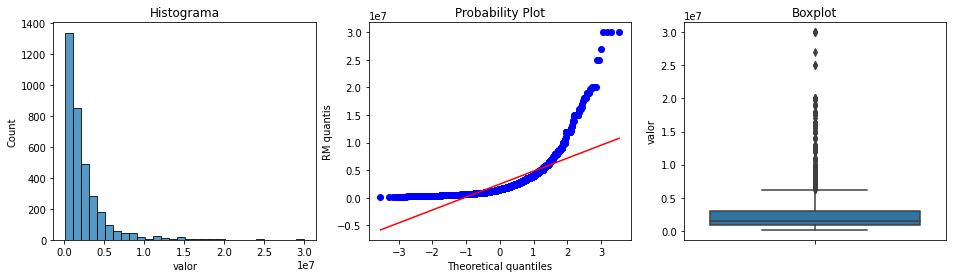

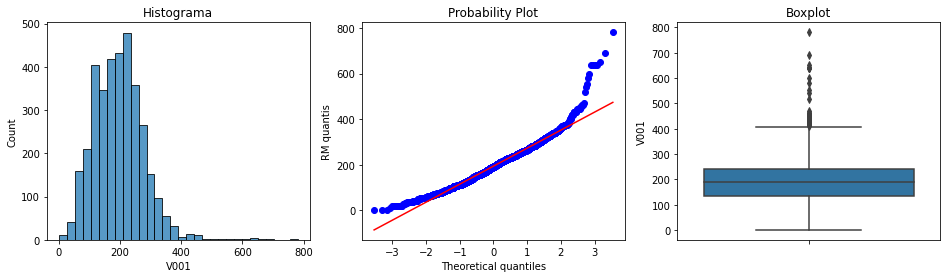

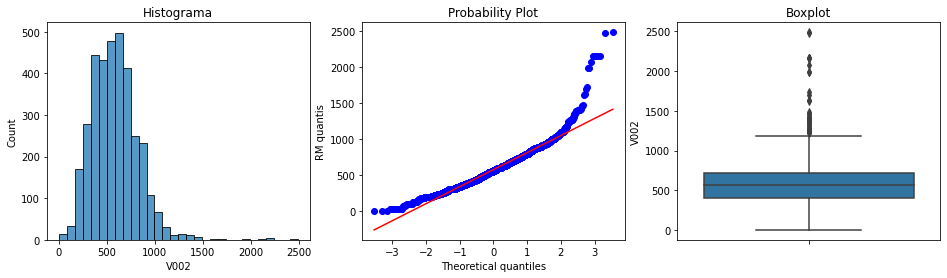

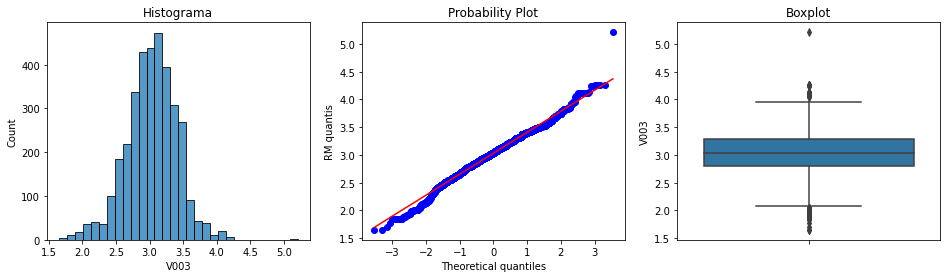

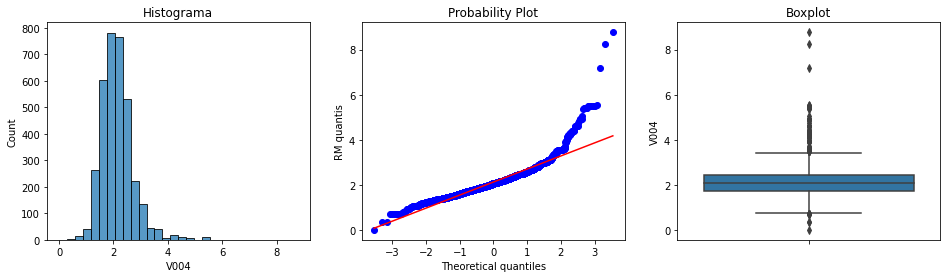

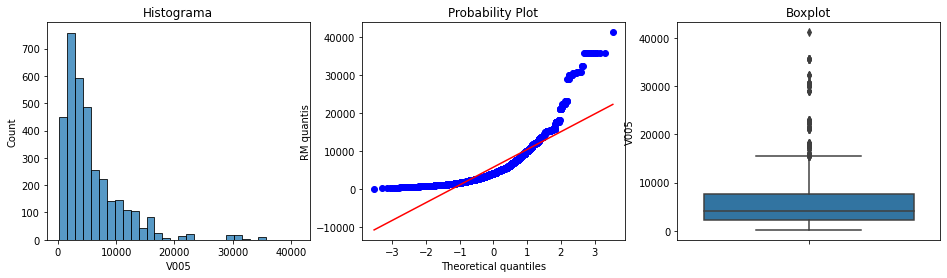

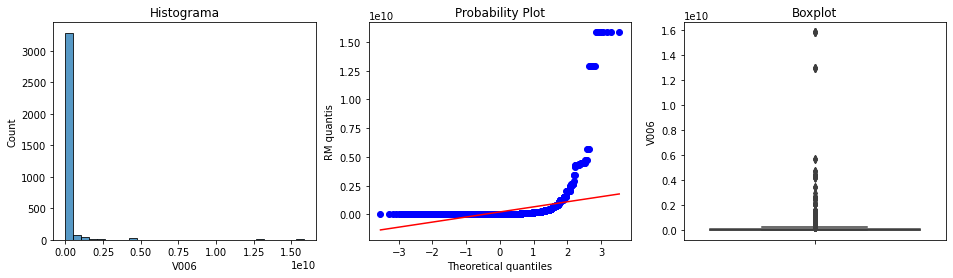

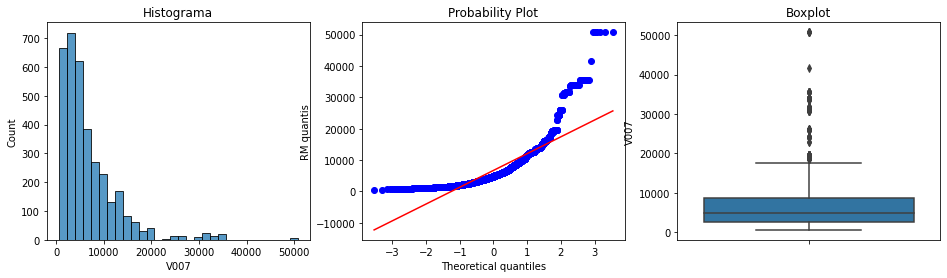

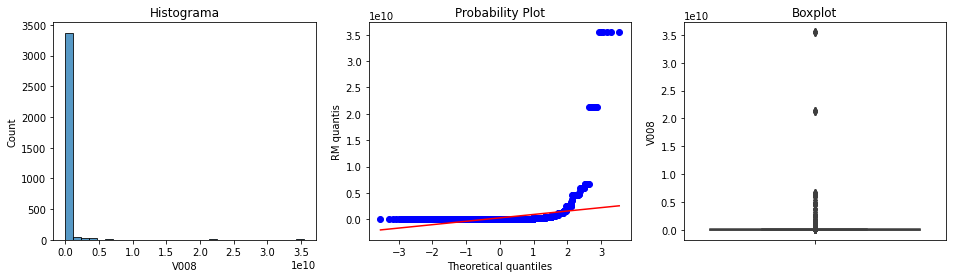

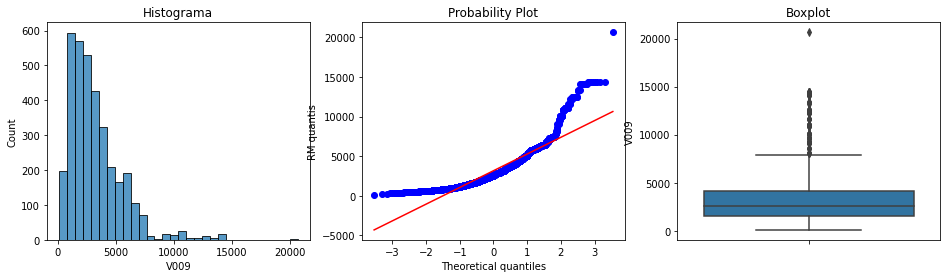

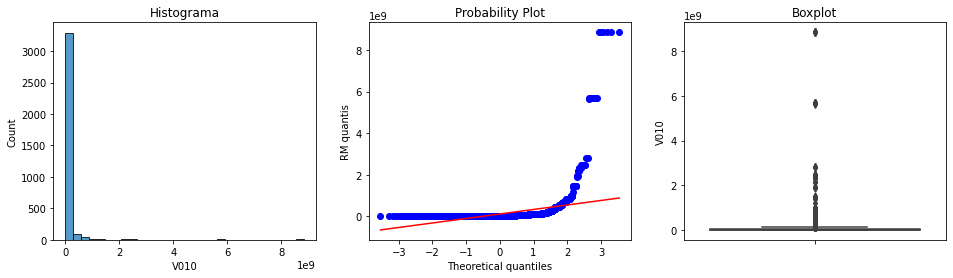

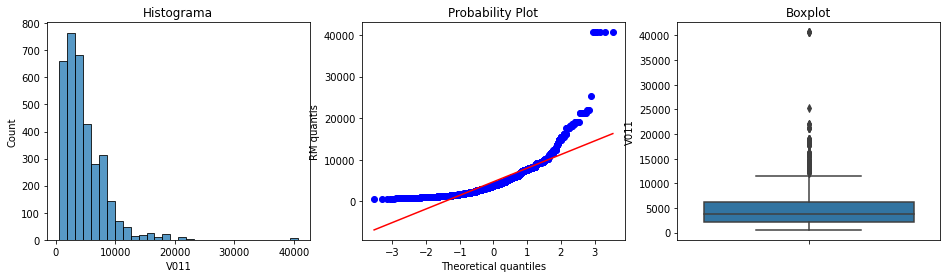

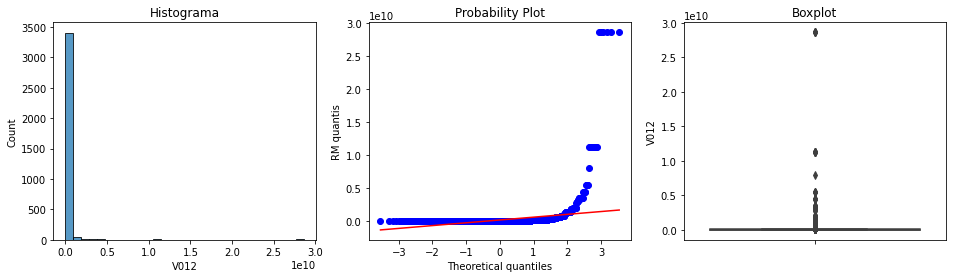

In [40]:
def diagnostic_plots(df, variable):
    # Função que retorna plots de diagnóstico das distribuição de probabilidade das variáveis

    # Ajustar tamanho figura
    plt.figure(figsize=(16, 4))

    # Histograma
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histograma')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantis')

    # Boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

for variable in dados_vendas_censo_sem_constantes.columns:
    diagnostic_plots(dados_vendas_censo_sem_constantes, variable)

In [41]:
# Separar dataframe em treino e validação
treino = dados_vendas_censo_sem_constantes.sample(frac = 0.8)
val = dados_vendas_censo_sem_constantes.drop(treino)

# Salvar arquivos no Drive para uso na aplicação
treino.to_csv('/content/drive/MyDrive/imersao_dados/train.csv')
val.to_csv('/content/drive/MyDrive/imersao_dados/test.csv')

In [42]:
# Separar conjunto de dados de treino para encaixe no modelo
X = treino.drop('valor', axis = 1)
y = treino['valor']
y = y.to_frame()

X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [43]:
# Limitar valores extremos
capper = Winsorizer(capping_method = 'quantiles', fold = 0.02, tail = 'both')
capper.fit(X_train)
X_train = capper.transform(X_train)
X_test = capper.transform(X_test)

In [44]:
# Padronizar escala das variáveis, já que o modelo de regressão é sensível a ela
scaler = StandardScaler()
target_scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns)

target_scaler.fit(y_train)

y_train = pd.DataFrame(
    target_scaler.transform(y_train))
y_test = pd.DataFrame(
    target_scaler.transform(y_test))

In [45]:
params = {
    "n_estimators": 200,
    "max_depth": 3,
    "min_samples_split": 20,
    "learning_rate": 0.1,
    "loss": "squared_error",
    "min_samples_leaf" : 50,
    "subsample" : 0.75, 
    "random_state" : 42
    }
lin_model = GradientBoostingRegressor(**params)
lin_model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(min_samples_leaf=50, min_samples_split=20,
                          n_estimators=200, random_state=42, subsample=0.75)

In [46]:
# fazer predições no conjunto de dados de treino
pred = lin_model.predict(X_train)
pred = pred.reshape(-1, 1)
yhat = target_scaler.inverse_transform(pred)
y_true = target_scaler.inverse_transform(y_train)
# determinar mse, rmse and r2
print('treino mse: {}'.format(int(
    mean_absolute_error(y_true, yhat))))
print('treino rmse: {}'.format(int(
    mean_squared_error(y_true, yhat, squared=False))))
print('treino r2: {}'.format(
    r2_score(y_true, yhat)))
print()

# fazer predições no conjunto de dados de teste
pred2 = lin_model.predict(X_test)
pred2 = pred2.reshape(-1, 1)
yhat = target_scaler.inverse_transform(pred2)
y_true = target_scaler.inverse_transform(y_test)
# determinar mse, rmse and r2
print('teste mse: {}'.format(int(
    mean_absolute_error(y_true, yhat))))
print('teste rmse: {}'.format(int(
    mean_squared_error(y_true, yhat, squared=False))))
print('teste r2: {}'.format(
    r2_score(y_true, yhat)))

treino mse: 753723
treino rmse: 1416737
treino r2: 0.7862342255535317

teste mse: 735854
teste rmse: 1306521
teste r2: 0.7500063251439286
